# Regression Models 
## Logistic regression

In [52]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

In [3]:
%matplotlib inline
rcParams['figure.figsize'] = 5, 4
sb.set_style('whitegrid')

## Logistic regression on the titanic dataset

In [43]:
titanic_training = pd.read_csv('titanic-training-data.csv')
titanic_training.columns = ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
print(titanic_training.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [13]:
print(titanic_training.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


##### VARIABLE DESCRIPTIONS

Survived - Survival (0 = No; 1 = Yes)<br>
Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)<br>
Name - Name<br>
Sex - Sex<br>
Age - Age<br>
SibSp - Number of Siblings/Spouses Aboard<br>
Parch - Number of Parents/Children Aboard<br>
Ticket - Ticket Number<br>
Fare - Passenger Fare (British pound)<br>
Cabin - Cabin<br>
Embarked - Port of Embarkation (C = Cherbourg, France; Q = Queenstown, UK; S = Southampton - Cobh, Ireland)

### Checking that your target variable is binary

<AxesSubplot:xlabel='Survived', ylabel='count'>

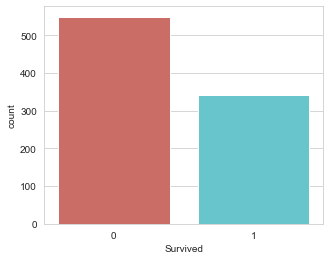

In [14]:
# we want to try and predict survival
sb.countplot(x='Survived', data=titanic_training, palette='hls')

### Checking for missing values

In [15]:
# our data meets the assumptions for the model before we actually try to implement the model to make a prediction
titanic_training.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [16]:
# count of rows/records
titanic_training.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Taking care of missing values
##### Dropping missing values
So let's just go ahead and drop all the variables that aren't relevant for predicting survival. We should at least keep the following:
- Survived - This variable is obviously relevant.
- Pclass - Does a passenger's class on the boat affect their survivability? -> 1st class passengers might have easier exit option (?)
- Sex - Could a passenger's gender impact their survival rate? -> if a woman is pregnant, it's gonna be harder to move in a mobile way to get off the boat
- Age - Does a person's age impact their survival rate? -> probably
- SibSp - Does the number of relatives on the boat (that are siblings or a spouse) affect a person survivability? Probability -> they might run slower to be looking for their sibling/spouse first (access to boat as time is running out)
- Parch - Does the number of relatives on the boat (that are children or parents) affect a person survivability? Probability -> they might run slower to be looking for their parents/children first (access to boat as time is running out)
- Fare - Does the fare a person paid effect his survivability? Maybe - let's keep it. (depending on the layout of the boat) or have class that has less exits
- Embarked - Does a person's point of embarkation matter? It depends on how the boat was filled... Let's keep it. (depending on the layout of the exit), e.g: if they filled the boat from front to back and they have more exits in the front of the boat, then definitely where the people embarked would make a difference on their survival rate

What about a person's name and ticket number? They're irrelavant for predicting survivability. And as you recall, the cabin variable is almost all missing values, so we can just drop all of these.

drop Cabin completely, make an approximation or fill in for missing values (because age really is a good predictor of survival rate)

In [17]:
titanic_data = titanic_training.drop(['Name', 'Ticket', 'Cabin'], axis=1)
titanic_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


### Imputing missing values

<AxesSubplot:xlabel='Parch', ylabel='Age'>

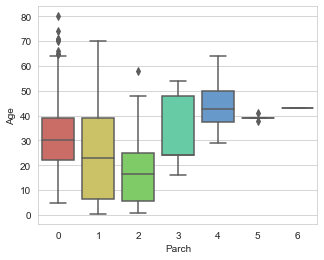

In [18]:
# impute missing values for 'age'
# Parch represents the number of relatives on the boat, that are either children or parents

sb.boxplot(x='Parch', y='Age', data=titanic_data, palette='hls')

# the younger the person, the more likely they have 2 relatives on the boat (probably gonna be parent) -> Parch = 2, median = 20
# the older the person, with median > 40, the more likely they have 4 relatives (individuals) (either parents/children)

<AxesSubplot:xlabel='SibSp', ylabel='Age'>

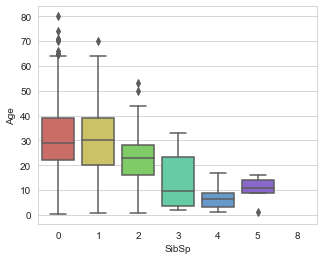

In [20]:
# check correlation 2 - not used
sb.boxplot(x='SibSp', y='Age', data=titanic_data, palette='hls')

# the younger the age, the more siblings/spouse they likely to have on boat
# the older the age, the less siblings/spouse they have on boat

In [32]:
parch_groupby = titanic_data.groupby(titanic_data['Parch'])
parch_groupby.count()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Fare,Embarked
Parch,,,,,,,,
0,678,678,678,678,521,678,678,676
1,118,118,118,118,110,118,118,118
2,80,80,80,80,68,80,80,80
3,5,5,5,5,5,5,5,5
4,4,4,4,4,4,4,4,4
5,5,5,5,5,5,5,5,5
6,1,1,1,1,1,1,1,1


In [34]:
parch_groupby.Age.describe()

,count,mean,std,min,25%,50%,75%,max
Parch,,,,,,,,
0,521.0,32.178503,12.570448,5.00,22.00,30.0,39.00,80.0
1,110.0,24.422000,18.283117,0.42,6.25,23.0,39.00,70.0
2,68.0,17.216912,13.193924,0.83,5.75,16.5,25.00,58.0
3,5.0,33.200000,16.709279,16.00,24.00,24.0,48.00,54.0
4,4.0,44.500000,14.617341,29.00,37.25,42.5,49.75,64.0
5,5.0,39.200000,1.095445,38.00,39.00,39.0,39.00,41.0
6,1.0,43.000000,NaN,43.00,43.00,43.0,43.00,43.0


In [22]:
# average age per 'Parch' category
Parch_groups = titanic_data.groupby(titanic_data['Parch'])
Parch_groups.mean()

# people that have 0 children/parents -> avg = 32

,PassengerId,Survived,Pclass,Age,SibSp,Fare
Parch,,,,,,
0,445.255162,0.343658,2.321534,32.178503,0.237463,25.586774
1,465.110169,0.550847,2.203390,24.422000,1.084746,46.778180
2,416.662500,0.500000,2.275000,17.216912,2.062500,64.337604
3,579.200000,0.600000,2.600000,33.200000,1.000000,25.951660
4,384.000000,0.000000,2.500000,44.500000,0.750000,84.968750
5,435.200000,0.200000,3.000000,39.200000,0.600000,32.550000
6,679.000000,0.000000,3.000000,43.000000,1.000000,46.900000


In [23]:
# average age per 'SibSp' category - not used
Parch_groups = titanic_data.groupby(titanic_data['SibSp'])
Parch_groups.mean()

,PassengerId,Survived,Pclass,Age,Parch,Fare
SibSp,,,,,,
0,455.370066,0.345395,2.351974,31.397558,0.185855,25.692028
1,439.727273,0.535885,2.057416,30.089727,0.655502,44.147370
2,412.428571,0.464286,2.357143,22.620000,0.642857,51.753718
3,321.562500,0.250000,2.562500,13.916667,1.312500,68.908862
4,381.611111,0.166667,3.000000,7.055556,1.500000,31.855556
5,336.800000,0.000000,3.000000,10.200000,2.000000,46.900000
8,481.714286,0.000000,3.000000,NaN,2.000000,69.550000


In [35]:
# loop through any of the rows where age has null values and make an approximation/assign a value based on 'Parch' category
# assign based on mean values of 'Parch' groupby
def age_approx(cols):
    Age = cols[0]
    Parch = cols[1]
    
    if pd.isnull(Age):
        if Parch == 0:
            return 32
        elif Parch == 1:
            return 24
        elif Parch == 2:
            return 17
        elif Parch == 3:
            return 33
        elif Parch == 4:
            return 45
        elif Parch == 5:
            return 39
        elif Parch == 6:
            return 43
        else:
            return 30 # avg mean of 'age' in titanic data set
        
    else:
        return Age # if it's got an 'Age' value in there, then we don't need to make approximation

In [36]:
pd.DataFrame(Parch_groups)

,0,1
0,0,PassengerId Survived Pclass Sex A...
1,1,PassengerId Survived Pclass Sex A...
2,2,PassengerId Survived Pclass Sex ...
3,3,PassengerId Survived Pclass Sex A...
4,4,PassengerId Survived Pclass Sex A...
5,5,PassengerId Survived Pclass Sex A...
6,8,PassengerId Survived Pclass Sex Ag...


In [37]:
titanic_data['Age']= titanic_data[['Age', 'Parch']].apply(age_approx, axis=1)
titanic_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       2
dtype: int64

In [38]:
# If you set inplace = True , the dropna method will modify your DataFrame directly. 
# That means that if you set inplace = True , dropna will drop all missing values from your original dataset. 
# It will overwrite your data
titanic_data.dropna(inplace=True)

# If you set drop = True , reset_index will delete the index instead of inserting it back into the columns of the DataFrame. 
# If you set drop = True , the current index will be deleted entirely and the numeric index will replace it.
titanic_data.reset_index(inplace=True, drop=True)

print(titanic_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Sex          889 non-null    object 
 4   Age          889 non-null    float64
 5   SibSp        889 non-null    int64  
 6   Parch        889 non-null    int64  
 7   Fare         889 non-null    float64
 8   Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 62.6+ KB
None


In [39]:
titanic_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


### Converting categorical variables to a dummy indicators

In [41]:
# convert 'sex' and 'embarked' to numeric variables
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
gender_cat = titanic_data['Sex']

# encode so it becomes either 0 or 1
gender_encoded = label_encoder.fit_transform(gender_cat)
gender_encoded[:5]

array([1, 0, 0, 0, 1])

In [42]:
titanic_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [44]:
# 1 -> male, 0 -> female
# create gender dataframe
gender_DF = pd.DataFrame(gender_encoded, columns = ['male_gender'])
gender_DF.head()

,male_gender
0,1
1,0
2,0
3,0
4,1


In [45]:
# have a numerica categorical that represents 'embarked'
embarked_cat = titanic_data['Embarked']
embarked_encoded = label_encoder.fit_transform(embarked_cat)
embarked_encoded[:100]

array([2, 0, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2,
       1, 2, 2, 2, 0, 2, 1, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0,
       1, 2, 1, 1, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2])

In [47]:
# One-hot encoding is a process by which categorical data (such as nominal data) are converted into numerical features 
# of a dataset. This is often a required preprocessing step since machine learning models require numerical data.
from sklearn.preprocessing import OneHotEncoder

# binary encoder
binary_encoder = OneHotEncoder(categories = 'auto')

#reshape as a single column
# (-1,1) -> gonna output an array that's actually a column array but we want that to be a matrix, e.g matrix(2,4) -> (8,1)
embarked_1hot = binary_encoder.fit_transform(embarked_encoded.reshape(-1,1)) 

# create another variable
embarked_1hot_mat = embarked_1hot.toarray()

embarked_DF = pd.DataFrame(embarked_1hot_mat, columns=['C','Q','S'])
embarked_DF.head()                                            

,C,Q,S
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0


In [48]:
titanic_data.drop(['Sex','Embarked'], axis=1, inplace=True)
titanic_data.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1,0,3,22.0,1,0,7.2500
1,2,1,1,38.0,1,0,71.2833
2,3,1,3,26.0,0,0,7.9250
3,4,1,1,35.0,1,0,53.1000
4,5,0,3,35.0,0,0,8.0500


In [50]:
# concantenate titanic_data with new datasets (dummy variables) as a column
titanic_dmy = pd.concat([titanic_data, gender_DF, embarked_DF], axis=1, verify_integrity=True).astype(float)
titanic_dmy.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male_gender,C,Q,S
0,1.0,0.0,3.0,22.0,1.0,0.0,7.2500,1.0,0.0,0.0,1.0
1,2.0,1.0,1.0,38.0,1.0,0.0,71.2833,0.0,1.0,0.0,0.0
2,3.0,1.0,3.0,26.0,0.0,0.0,7.9250,0.0,0.0,0.0,1.0
3,4.0,1.0,1.0,35.0,1.0,0.0,53.1000,0.0,0.0,0.0,1.0
4,5.0,0.0,3.0,35.0,0.0,0.0,8.0500,1.0,0.0,0.0,1.0


### Checking for independence between features

<AxesSubplot:>

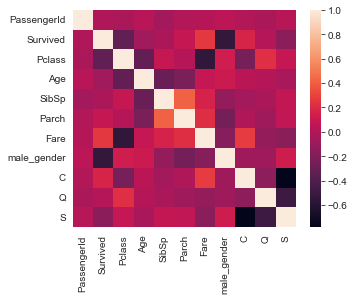

In [55]:
# seaborn heatmap function to see correlation between variables
# logistic regression assumes that features are independent of one another
# see what values are very light that are close to 1
sb.heatmap(titanic_dmy.corr())

In [ ]:
# 'Pclass' & 'Fare' not independent of one another, so just drop those
titanic_dmy.drop(['Fare','Pclass'], axis=1, inplace=True)

In [60]:
titanic_dmy.columns

Index(['PassengerId', 'Survived', 'Age', 'SibSp', 'Parch', 'male_gender', 'C',
       'Q', 'S'],
      dtype='object')

In [62]:
titanic_dmy.head()

,PassengerId,Survived,Age,SibSp,Parch,male_gender,C,Q,S
0,1.0,0.0,22.0,1.0,0.0,1.0,0.0,0.0,1.0
1,2.0,1.0,38.0,1.0,0.0,0.0,1.0,0.0,0.0
2,3.0,1.0,26.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4.0,1.0,35.0,1.0,0.0,0.0,0.0,0.0,1.0
4,5.0,0.0,35.0,0.0,0.0,1.0,0.0,0.0,1.0


### Checking that your dataset size is sufficient

#### to do logistic regression, check how many variables do we have
#### at least you have 50 records/predictive feature
#### we have 6 predictors -> ('C','Q','S'): 1 predictive variable, male_gender, Parch, SibSp, Age, PassengerId
#### 50 records/predictive feature x 6 predictors -> 300 records

In [63]:
titanic_dmy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    float64
 1   Survived     889 non-null    float64
 2   Age          889 non-null    float64
 3   SibSp        889 non-null    float64
 4   Parch        889 non-null    float64
 5   male_gender  889 non-null    float64
 6   C            889 non-null    float64
 7   Q            889 non-null    float64
 8   S            889 non-null    float64
dtypes: float64(9)
memory usage: 62.6 KB


In [66]:
# break data into training and pass set, not include survive variable -> this is what we're predicting for
# y-variable -> the 'Survived', split 80 train-20 test
# random_state = seed -> to get the same result
X_train, X_test, y_train, y_test = train_test_split(titanic_dmy.drop('Survived', axis=1),
                                                   titanic_dmy['Survived'], test_size=0.2,
                                                   random_state = 200)

In [67]:
# shape of outputs
print(X_train.shape)
print(y_train.shape)

(711, 8)
(711,)


In [68]:
X_train.head()

,PassengerId,Age,SibSp,Parch,male_gender,C,Q,S
719,721.0,6.0,0.0,1.0,0.0,0.0,0.0,1.0
165,167.0,24.0,0.0,1.0,0.0,0.0,0.0,1.0
879,882.0,33.0,0.0,0.0,1.0,0.0,0.0,1.0
451,453.0,30.0,0.0,0.0,1.0,1.0,0.0,0.0
181,183.0,9.0,4.0,2.0,1.0,0.0,0.0,1.0


### Deploying and evaluating the model

In [70]:
# instantoate the logistic regression model and set solver
LogReg = LogisticRegression(solver='liblinear')

# fit the model
# Fit function adjusts weights according to data values so that better accuracy can be achieved. 
# After training, the model can be used for predictions
LogReg.fit(X_train, y_train)

# Model fitting is a measure of how well a machine learning model generalizes to similar data to that on which it was trained. 
# A model that is well-fitted produces more accurate outcomes. A model that is overfitted matches the data too closely.

LogisticRegression(solver='liblinear')

In [71]:
# create a prediction from LogReg
y_pred = LogReg.predict(X_test)

## Model Evaluation
### Classification report without cross-validation

In [72]:
# test how well our model performs
# use classification report and confusion matrices
print(classification_report(y_test, y_pred))

# get the precision and recall average around 81% (bottom)

              precision    recall  f1-score   support

         0.0       0.83      0.88      0.85       109
         1.0       0.79      0.71      0.75        69

    accuracy                           0.81       178
   macro avg       0.81      0.80      0.80       178
weighted avg       0.81      0.81      0.81       178



### K-fold cross-validation & confusion matrices

In [73]:
# CV (cv) means Cross Validation. This is the score in your validation set. 
# In a competition, the LB normally is computed only 20-30 % test data

# when you are passing cv=5 you are using the StratifiedKFold strategy, w
# hereas when passing cv=kf you are using the regular KFold strategy. 
# In classification, stratification generally attempts to ensure that each test fold has approximately 
# equal class representation
y_train_pred = cross_val_predict(LogReg, X_train, y_train, cv=5)
confusion_matrix(y_train, y_train_pred)

# confusion matrix telling us that 377 & 180 are the number of correct predictions
# 91 & 63 are the number of incorrect predictions

array([[377,  63],
       [ 91, 180]], dtype=int64)

In [74]:
# if we want to generate a precision score, we can use precision score function
precision_score(y_train, y_train_pred)

0.7407407407407407

### Make a test prediction

In [75]:
# how our models operates in predictive mode, pull titanic_dmy data and get record at index 863
titanic_dmy[863:864]

,PassengerId,Survived,Age,SibSp,Parch,male_gender,C,Q,S
863,866.0,1.0,42.0,0.0,0.0,0.0,0.0,0.0,1.0


In [76]:
# test passenger then create test values to see if our model predicts that the person survived
# input evertyhting but 'Survived'
# Reshape your data either using array. reshape(-1, 1) if your data has a single feature or array. 
# reshape(1, -1) if it contains a single sample.
test_passenger = np.array([866, 40, 0, 0, 0, 0, 0, 1]).reshape(1,-1)

# make a prediction and a probability of whether or not that prediction is correct
print(LogReg.predict(test_passenger))

# probability of being correct
print(LogReg.predict_proba(test_passenger))

# the model predicted this person will survive because the person at index 863 survived
# these 2 individuals would in theory be most identical except for age
# probability of the prediction is correct is about 73%

[1.]
[[0.26351831 0.73648169]]


C:\Users\HP\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
